In [23]:
!pip -q install pyshp
!pip -q install influxdb
!pip -q install shapely
!pip -q install plotly
!pip -q install tensorflow

In [38]:
import shapefile
import pandas as pd
import numpy as np
from influxdb import DataFrameClient
from shapely.geometry import Point, Polygon
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv
import matplotlib
import matplotlib.pyplot as plt
import time
from multiprocessing import Process, Queue
import tensorflow as tf
from tensorflow import keras
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler

%matplotlib inline
%config InlineBackend.figure_format='retina' # make figure more clear

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

load_dotenv()

In [25]:
def rm_outside_polygon(res_pd_frame,polygon):
    res_pd_frame_1 = res_pd_frame[['lon','lat','sensor_id']]
    res_pd_frame_2 = res_pd_frame_1.reset_index()
    res_pd_frame_3 = res_pd_frame_2.drop(columns=['index'])
    res_pd_frame4 = res_pd_frame_3.drop_duplicates()
    res_pd_frame4["polygon1"] = res_pd_frame4.apply(lambda row: Polygon(poly).intersects(Point(row["lon"], row["lat"])), axis = 1)
    res_pd_frame5 = res_pd_frame4.drop(res_pd_frame4[res_pd_frame4["polygon1"]].index)
    res_pd_frame = res_pd_frame[~res_pd_frame.sensor_id.isin(res_pd_frame5.sensor_id)]     
    return res_pd_frame

In [26]:
#sf = shapefile.Reader("landkreise-in-germany.shp") # This is Göttingen
#s = sf.shape(0)

sf = shapefile.Reader("bundesland.shp") # Complete germany, 16 shapes for each bundesland
s = sf.shape(3) # Baden-Württemberg
poly = Polygon(s.points)  # Convert to polygon to use shapely function point.within(polygon)

In [27]:
def main(host=os.getenv("HOST"), port=os.getenv("PORT"), rectangle=[0,0,0,0],time_range=["",""],limit=100):
    """Instantiate the connection to the InfluxDB client."""
    user = os.getenv("USER")
    password = os.getenv("PASSWORD")
    dbname = os.getenv("DB")
    protocol = 'line'

    client = DataFrameClient(host, port, user, password, dbname, ssl=True, verify_ssl=True)

    bind_params = {
        "start_time_epoch": time_range[0],
        "end_time_epoch": time_range[1]
    }
    
    measurement = "temperature, humidity, P1, lat, lon, sensor_id"
    
    query = f"select {measurement} from sensor where \
                     time > $start_time_epoch AND \
                     time < $end_time_epoch AND \
                     lon > {rectangle[0]} AND \
                     lon < {rectangle[2]} AND \
                     lat > {rectangle[1]} AND \
                     lat < {rectangle[3]} \
                     limit {limit}"
                
    res=client.query(query, bind_params=bind_params)
    return res

In [28]:
start_date = datetime(2017, 1, 2)
end_date = start_date + timedelta(hours=1)

date_to_start_query = start_date
date_to_end_query = datetime(2017, 1, 6)

In [29]:
Q_temp = Queue()
Q_humi = Queue()
Q_P1 = Queue()

In [30]:
def main_temp():
    temp_appended_res_pd_frame_plot_timeindex = []
    
    global start_time
    global start_date
    global end_date
       
    j = 0
    number = 5
    while number >= 5:

        start_time = time.time()

        time_range=[start_date.strftime("%Y-%m-%dT%H:%M:%SZ"),end_date.strftime("%Y-%m-%dT%H:%M:%SZ")]
        print(time_range)

        res=main(rectangle=s.bbox,time_range=time_range,limit=10000)

        if not res:
            print('Data empty in %s' %time_range)
            start_date=end_date
            end_date=start_date + timedelta(hours=1)

        if res:    
            res_pd_frame=rm_outside_polygon(res['sensor'],poly)

            if 'temperature' in res_pd_frame.keys():
                    res_pd_frame.dropna(subset=['temperature'],inplace = True)

            res_pd_frame_drop = res_pd_frame.drop(['lat', 'lon'], axis = 1)

            res_pd_frame_mean = res_pd_frame_drop.groupby(['sensor_id'],as_index=True)['temperature'].mean()

            res_pd_frame_mean = res_pd_frame_mean.to_frame()

            res_pd_frame_plot = res_pd_frame_mean.swapaxes("index", "columns") 
            res_pd_frame_plot_timeindex = res_pd_frame_plot.rename(index={'temperature': start_date})
            res_pd_frame_plot_timeindex

            temp_appended_res_pd_frame_plot_timeindex.append(res_pd_frame_plot_timeindex)

            start_date=end_date
            end_date=start_date + timedelta(hours=1)
            print("--- %s seconds ---" % (time.time() - start_time))

        if start_date == date_to_end_query:
            break

    temp_appended_res_pd_frame_plot_timeindex = pd.concat(temp_appended_res_pd_frame_plot_timeindex)
    temp_appended_res_pd_frame_plot_timeindex.index.name = 'timestamp'
    temp_appended_res_pd_frame_plot_timeindex
    
    temp_df = temp_appended_res_pd_frame_plot_timeindex
    
    Q_temp.put(temp_df)

In [31]:
def main_humi():
    humi_appended_res_pd_frame_plot_timeindex = []

    global start_time
    global start_date
    global end_date
        
    j = 0
    number = 5
    while number >= 5:
        
        
        start_time = time.time()

        time_range=[start_date.strftime("%Y-%m-%dT%H:%M:%SZ"),end_date.strftime("%Y-%m-%dT%H:%M:%SZ")]
        print(time_range)

        res=main(rectangle=s.bbox,time_range=time_range,limit=10000)

        if not res:
            print('Data empty in %s' %time_range)
            start_date=end_date
            end_date=start_date + timedelta(hours=1)

        if res:    
            res_pd_frame=rm_outside_polygon(res['sensor'],poly)

            if 'humidity' in res_pd_frame.keys():
                    res_pd_frame.dropna(subset=['humidity'],inplace = True)

            res_pd_frame_drop = res_pd_frame.drop(['lat', 'lon'], axis = 1)

            res_pd_frame_mean = res_pd_frame_drop.groupby(['sensor_id'],as_index=True)['humidity'].mean()

            res_pd_frame_mean = res_pd_frame_mean.to_frame()

            res_pd_frame_plot = res_pd_frame_mean.swapaxes("index", "columns") 
            res_pd_frame_plot_timeindex = res_pd_frame_plot.rename(index={'humidity': start_date})
            res_pd_frame_plot_timeindex

            humi_appended_res_pd_frame_plot_timeindex.append(res_pd_frame_plot_timeindex)

            start_date=end_date
            end_date=start_date + timedelta(hours=1)
            print("--- %s seconds ---" % (time.time() - start_time))

        if start_date == date_to_end_query:
            break

    humi_appended_res_pd_frame_plot_timeindex = pd.concat(humi_appended_res_pd_frame_plot_timeindex)
    humi_appended_res_pd_frame_plot_timeindex.index.name = 'timestamp'
    humi_appended_res_pd_frame_plot_timeindex
    
    humi_df = humi_appended_res_pd_frame_plot_timeindex
    
    Q_humi.put(humi_df)

In [32]:
def main_P1():
    P1_appended_res_pd_frame_plot_timeindex = []

    global start_time
    global start_date
    global end_date
    
    j = 0
    number = 5
    while number >= 5:
        start_time = time.time()

        time_range=[start_date.strftime("%Y-%m-%dT%H:%M:%SZ"),end_date.strftime("%Y-%m-%dT%H:%M:%SZ")]
        print(time_range)

        res=main(rectangle=s.bbox,time_range=time_range,limit=10000)

        if not res:
            print('Data empty in %s' %time_range)
            start_date=end_date
            end_date=start_date + timedelta(hours=1)

        if res:    
            res_pd_frame=rm_outside_polygon(res['sensor'],poly)

            if 'P1' in res_pd_frame.keys():
                    res_pd_frame.dropna(subset=['P1'],inplace = True)

            res_pd_frame_drop = res_pd_frame.drop(['lat', 'lon'], axis = 1)

            res_pd_frame_mean = res_pd_frame_drop.groupby(['sensor_id'],as_index=True)['P1'].mean()

            res_pd_frame_mean = res_pd_frame_mean.to_frame()

            res_pd_frame_plot = res_pd_frame_mean.swapaxes("index", "columns") 
            res_pd_frame_plot_timeindex = res_pd_frame_plot.rename(index={'P1': start_date})
            res_pd_frame_plot_timeindex

            P1_appended_res_pd_frame_plot_timeindex.append(res_pd_frame_plot_timeindex)

            start_date=end_date
            end_date=start_date + timedelta(hours=1)
            print("--- %s seconds ---" % (time.time() - start_time))

        if start_date == date_to_end_query:
            break

    P1_appended_res_pd_frame_plot_timeindex = pd.concat(P1_appended_res_pd_frame_plot_timeindex)
    P1_appended_res_pd_frame_plot_timeindex.index.name = 'timestamp'
    P1_appended_res_pd_frame_plot_timeindex
    
    P1_df = P1_appended_res_pd_frame_plot_timeindex
    
    Q_P1.put(P1_df)

In [33]:
p = Process(target=main_temp)
p.start()

p1 = Process(target=main_humi)
p1.start()

p2 = Process(target=main_P1)
p2.start()

temp_frame = Q_temp.get()
humi_frame = Q_humi.get()
P1_frame = Q_P1.get()

p.join()
p1.join()
p2.join()

['2017-01-02T00:00:00Z', '2017-01-02T01:00:00Z']
['2017-01-02T00:00:00Z', '2017-01-02T01:00:00Z']
['2017-01-02T00:00:00Z', '2017-01-02T01:00:00Z']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


--- 3.1666228771209717 seconds ---
['2017-01-02T01:00:00Z', '2017-01-02T02:00:00Z']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


--- 3.2160110473632812 seconds ---
['2017-01-02T01:00:00Z', '2017-01-02T02:00:00Z']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


--- 3.277071475982666 seconds ---
['2017-01-02T01:00:00Z', '2017-01-02T02:00:00Z']
--- 2.763474702835083 seconds ---
['2017-01-02T02:00:00Z', '2017-01-02T03:00:00Z']
--- 2.831728219985962 seconds ---
['2017-01-02T02:00:00Z', '2017-01-02T03:00:00Z']
--- 3.0510659217834473 seconds ---
['2017-01-02T02:00:00Z', '2017-01-02T03:00:00Z']
--- 2.736318588256836 seconds ---
['2017-01-02T03:00:00Z', '2017-01-02T04:00:00Z']
--- 3.529217004776001 seconds ---
['2017-01-02T03:00:00Z', '2017-01-02T04:00:00Z']
--- 4.15381932258606 seconds ---
['2017-01-02T03:00:00Z', '2017-01-02T04:00:00Z']
--- 3.1345860958099365 seconds ---
['2017-01-02T04:00:00Z', '2017-01-02T05:00:00Z']
--- 3.1529159545898438 seconds ---
['2017-01-02T04:00:00Z', '2017-01-02T05:00:00Z']
--- 3.131944417953491 seconds ---
['2017-01-02T04:00:00Z', '2017-01-02T05:00:00Z']
--- 2.4498836994171143 seconds ---
['2017-01-02T05:00:00Z', '2017-01-02T06:00:00Z']
--- 2.143859624862671 seconds ---
['2017-01-02T05:00:00Z', '2017-01-02T06:00:00Z']
-

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



--- 2.2172086238861084 seconds ---
['2017-01-05T21:00:00Z', '2017-01-05T22:00:00Z']
--- 2.4829261302948 seconds ---
['2017-01-05T23:00:00Z', '2017-01-06T00:00:00Z']
--- 2.28230357170105 seconds ---
['2017-01-05T22:00:00Z', '2017-01-05T23:00:00Z']
--- 2.202043056488037 seconds ---


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



--- 2.8731582164764404 seconds ---
['2017-01-05T23:00:00Z', '2017-01-06T00:00:00Z']
--- 2.327669620513916 seconds ---


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [34]:
temp_frame.dropna(axis=1, inplace=True)
humi_frame.dropna(axis=1, inplace=True)
P1_frame.dropna(axis=1, inplace=True)

In [35]:
temp_frame = temp_frame[['163']]
humi_frame = humi_frame[['163']]
P1_frame = P1_frame[['162']]

In [36]:
df = pd.concat([temp_frame, humi_frame, P1_frame], axis=1, sort=False)
df.columns = ['163_temp', '163_humi', '162_P1']
df

,163_temp,163_humi,162_P1
timestamp,,,
2017-01-02 00:00:00,-1.856604,87.324528,289.367143
2017-01-02 01:00:00,-1.638298,88.702128,242.976935
2017-01-02 02:00:00,-1.750980,90.174510,285.346935
2017-01-02 03:00:00,-1.641304,90.613043,179.220000
2017-01-02 04:00:00,-1.566129,89.303226,171.268548
...,...,...,...
2017-01-05 19:00:00,-2.114516,66.580645,17.145161
2017-01-05 20:00:00,-2.690323,73.570968,15.509194
2017-01-05 21:00:00,-2.722581,73.801613,16.010161


In [48]:
minmax = RobustScaler().fit(df.iloc[:, 1:2].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 1:2].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.271264
1,0.376281
2,0.488523
3,0.521954
4,0.422104


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


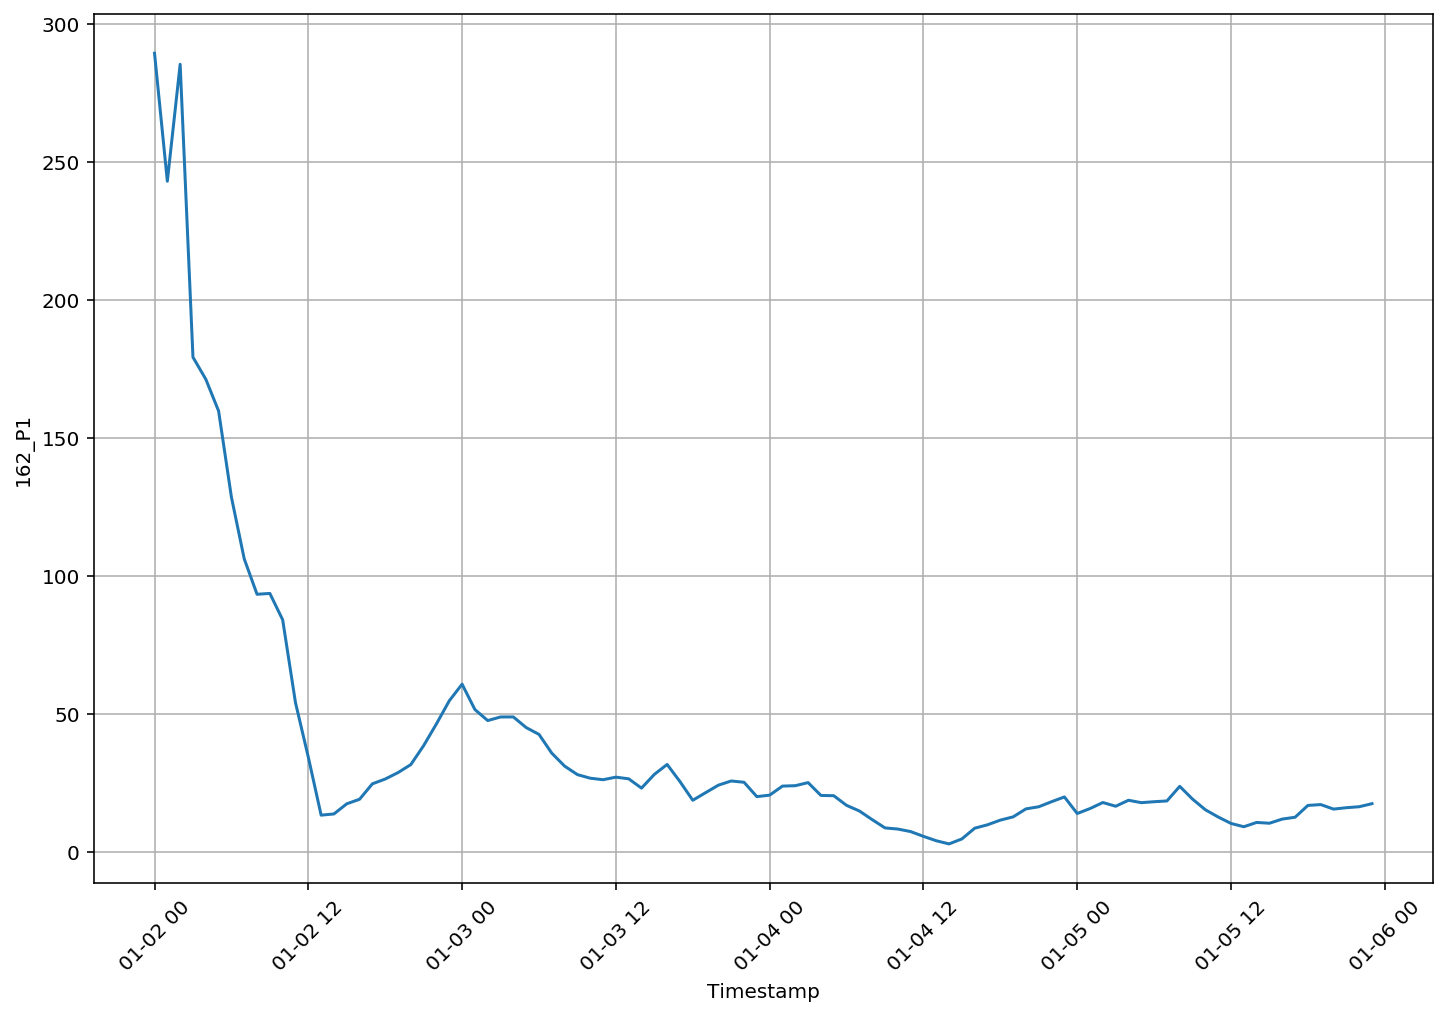

In [42]:
plt.plot(df.index, '162_P1', data=df)
plt.xticks(rotation=45)
plt.ylabel('162_P1')
plt.xlabel('Timestamp')
plt.grid()
plt.show()

# Split dataset into training and test data

In [43]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train = df.iloc[0:train_size]
test = df.iloc[train_size:len(df)]
print(len(train), len(test))

76 20


# Scaling other features which are also used for the modeling

In [44]:
features = ['163_temp', '163_humi']

f_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[features].to_numpy())

train.loc[:, features] = f_transformer.transform(train[features].to_numpy())

test.loc[:, features] = f_transformer.transform(test[features].to_numpy())

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/co

# Scaling the feature which we need to do forecasting on

In [45]:
P1_transformer = RobustScaler()

P1_transformer = P1_transformer.fit(train[['162_P1']])

train['162_P1'] = P1_transformer.transform(train[['162_P1']])

test['162_P1'] = P1_transformer.transform(test[['162_P1']])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


# Preparing the data for Time Series forecasting (LSTM)

In [46]:
def create_dataset(X, y, time_steps=1):
    Xs = []
    ys = []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [47]:
time_steps = 1

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train['162_P1'], time_steps)
X_test, y_test = create_dataset(test, test['162_P1'], time_steps)

print(X_train.shape, y_train.shape)

(75, 1, 3) (75,)


In [21]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [22]:
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Train on 568 samples, validate on 64 samples
Epoch 1/50
568/568 [==============================] - 3s 6ms/sample - loss: 1.3921 - val_loss: 0.2933
Epoch 2/50
568/568 [==============================] - 0s 151us/sample - loss: 1.0812 - val_loss: 0.2097
Epoch 3/50
568/568 [==============================] - 0s 169us/sample - loss: 0.8283 - val_loss: 0.1443
Epoch 4/50
568/568 [==============================] - 0s 149us/sample - loss: 0.6056 - val_loss: 0.0979
Epoch 5/50
568/568 [==============================] - 0s 134us/sample - loss: 0.4219 - val_loss: 0.0707
Epoch 6/50
568/568 [==============================] - 0s 140us/sample - loss: 0.2832 - val_loss: 0.0601
Epoch 7/50
568/568 [==============================] - 0s 150us/sample - loss: 0.1980 - val_loss: 0.0591
Epoch 8/50
568/568 [==============================] - 0s 139us/sample - loss: 0.1481 - val_loss: 0.0586
Epoch 9/50
568/568 [==============================] - 0s 152us/sample - loss: 0.1187 - val_loss: 0.0542
Epoch 10/50
568/568 [

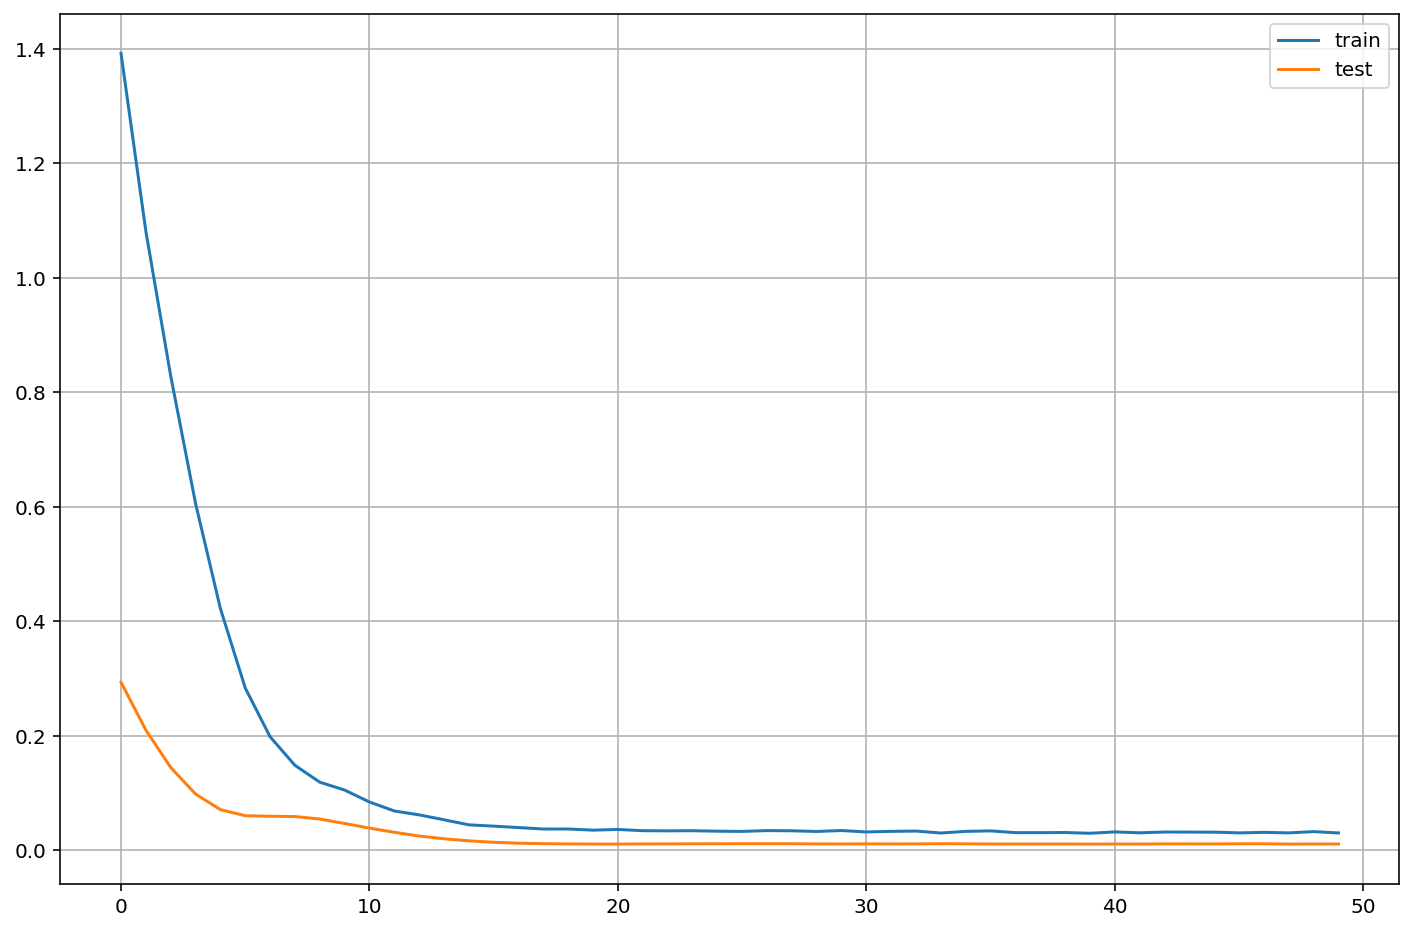

In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.grid()
plt.legend();

In [24]:
y_pred = model.predict(X_test)

In [25]:
y_train_inverse = P1_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inverse = P1_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inverse = P1_transformer.inverse_transform(y_pred)

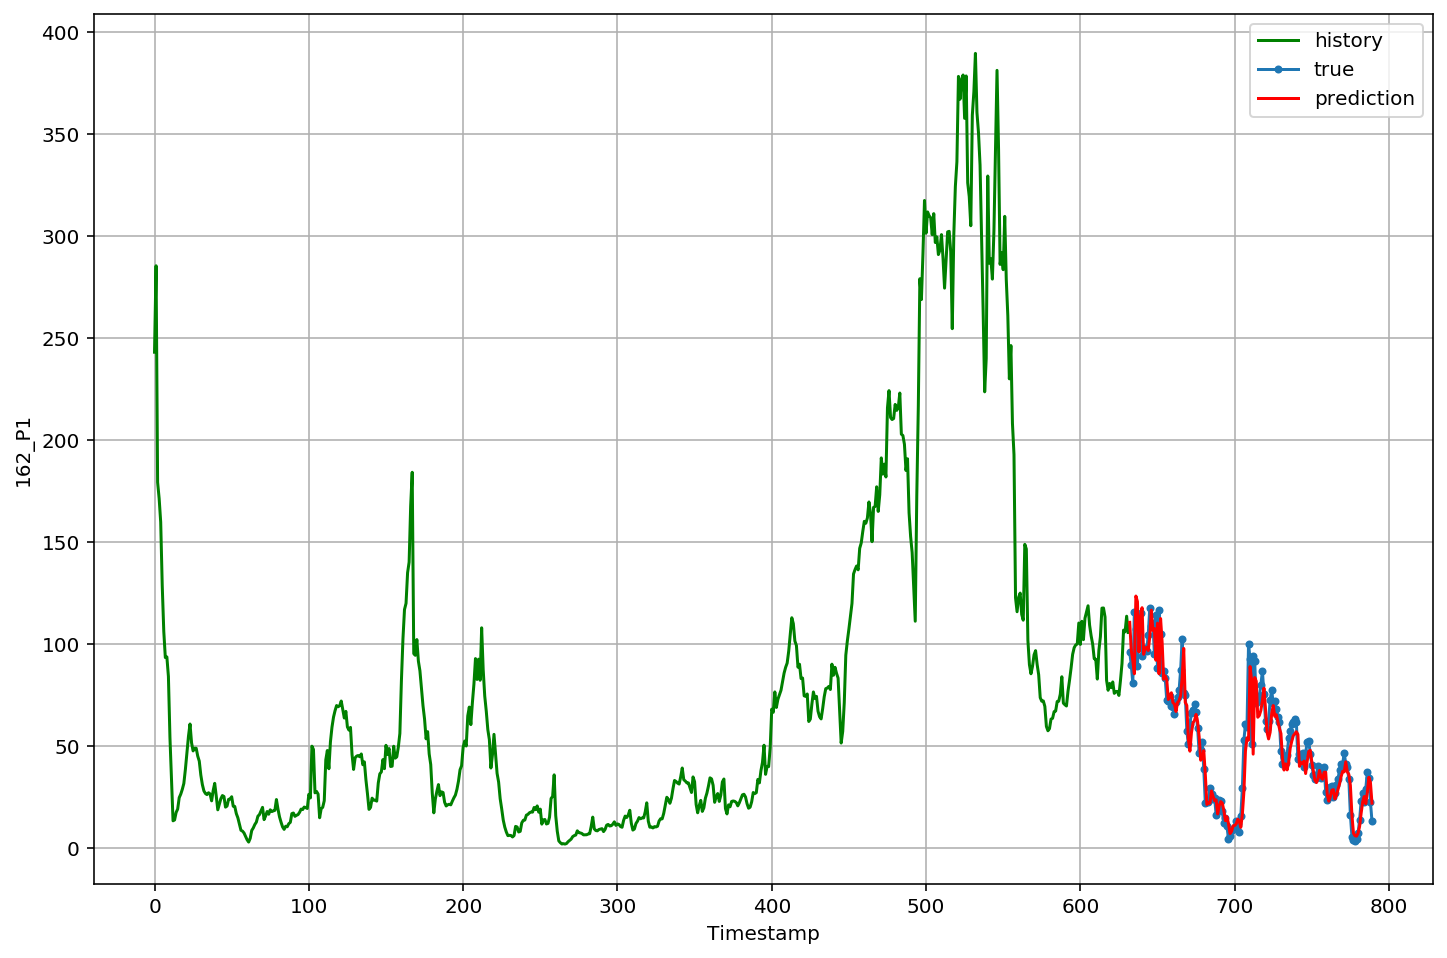

In [26]:
plt.plot(np.arange(0, len(y_train)), y_train_inverse.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inverse.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inverse.flatten(), 'r', label="prediction")
plt.ylabel('162_P1')
plt.xlabel('Timestamp')
plt.legend()
plt.grid()
plt.show()

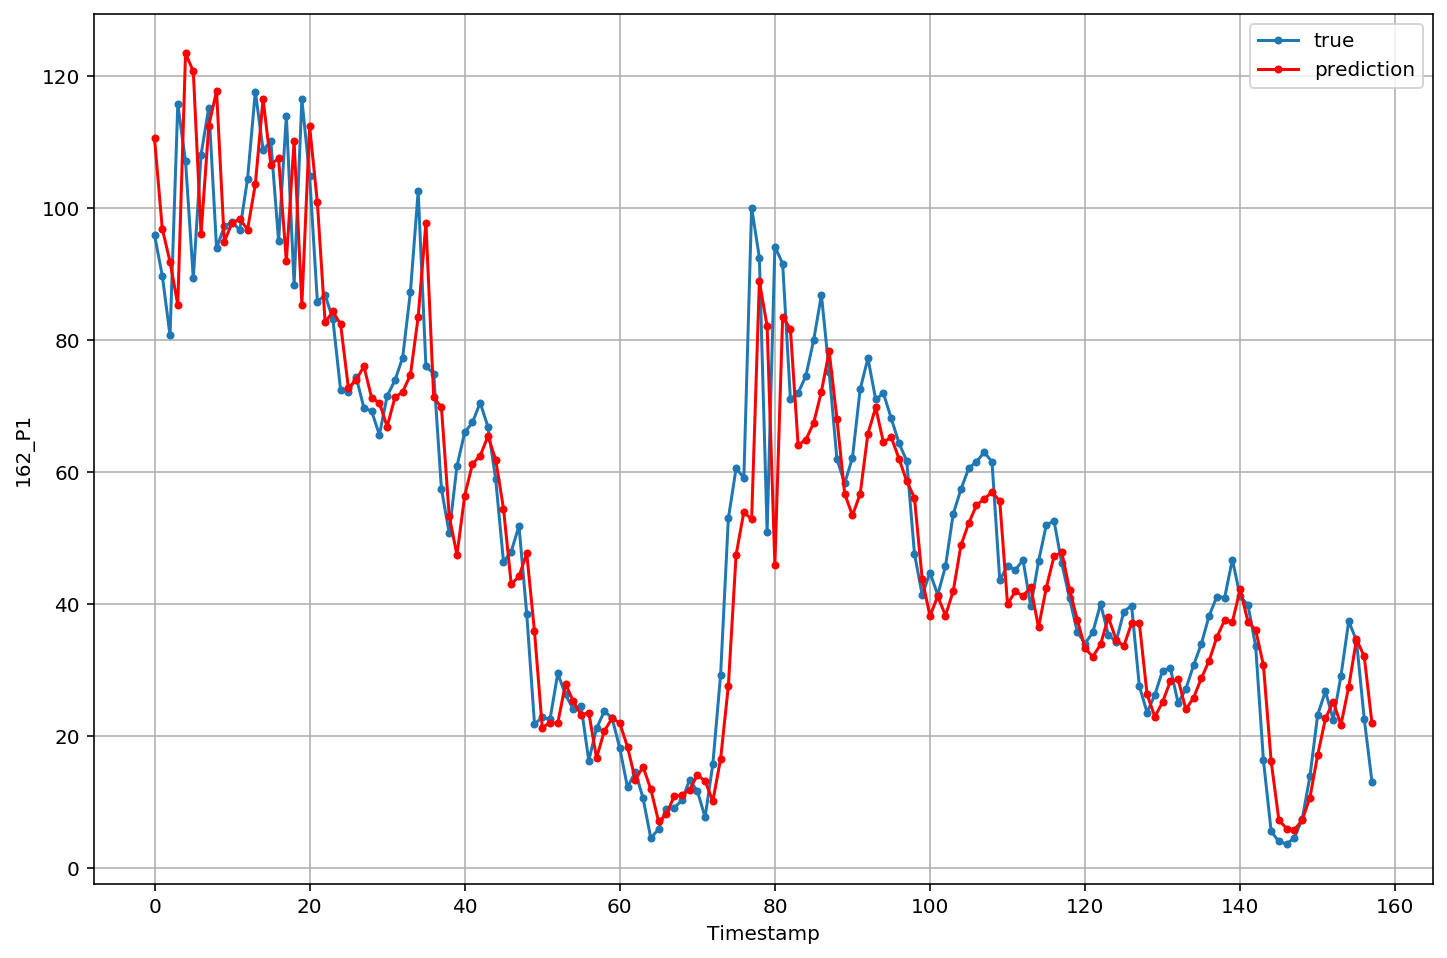

In [27]:
plt.plot(y_test_inverse.flatten(), marker='.', label="true")
plt.plot(y_pred_inverse.flatten(), 'r', marker='.', label="prediction")
plt.ylabel('162_P1')
plt.xlabel('Timestamp')
plt.legend()
plt.grid()
plt.show()